Сценарное моделирование для датасета Movielens. В этом ноутбуке показан процесс обучения рекомендательной системы в симуляторе с использованием синтетических пользоваетелей для разных долей пользователей из соответствующих кластеров. В случае Movielens пользователи поделены на 10 классов с помощью кластеризации распределении жанров

In [1]:
import warnings
warnings.filterwarnings("ignore")

import time
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE

from pyspark.sql import SparkSession
from replay.session_handler import State

import pyspark.sql.functions as sf
import pyspark.ml.functions as smf
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml import Pipeline

from replay.metrics import NDCG
from replay.data_preparator import Indexer

from simulator.modules import SDVDataGenerator, RealDataGenerator, CompositeGenerator
from simulator.modules import Simulator, EvaluateMetrics
from simulator.response import BernoulliResponse, ParametricResponseFunction
from simulator.utils import VectorElementExtractor, pandas_to_spark

from replay.models import UCB
from datautils import *

%matplotlib inline
import matplotlib.pyplot as plt

SPARK_LOCAL_DIR = '/data/home/anthony/tmp'
CHECKPOINT_DIR = '/data/home/anthony/tmp/checkpoints'
DATA_PATH = r'file:///data/home/anthony/DL_0/real_data_simulator/Movielens'
MODELS_DIR = '../bin'

spark = SparkSession.builder\
    .appName('movielens_scenario')\
    .master('local[16]')\
    .config('spark.sql.shuffle.partitions', '16')\
    .config('spark.default.parallelism', '16')\
    .config('spark.driver.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.executor.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.sql.autoBroadcastJoinThreshold', '-1')\
    .config('spark.driver.memory', '128g')\
    .config('spark.local.dir', SPARK_LOCAL_DIR)\
    .getOrCreate()

State(spark)

22/11/18 11:42:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/11/18 11:42:58 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [2]:
users_df_train, items_df_train, log_df_train = read_movielens(DATA_PATH, 'train', spark)

users_df_train = users_df_train.cache()
items_df_train = items_df_train.cache()
log_df_train = log_df_train.cache()

users_df_train.count()
items_df_train.count()
log_df_train.count()

22/11/18 11:43:38 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


10000132

In [3]:
users_df_val, items_df_val, log_df_val = read_movielens(DATA_PATH, 'val', spark)

users_df_val = users_df_val.cache()
items_df_val = items_df_val.cache()
log_df_val = log_df_val.cache()

users_df_val.count()
items_df_val.count()
log_df_val.count()

5000065

In [4]:
pca_va = VectorAssembler(
    inputCols=['user_rating_avg'] + [f'user_genre{i}' for i in range(19)] + [f'user_w2v_{i}' for i in range(300)],
    outputCol='features'
)
pca_estimator = PCA(k=9, inputCol='features', outputCol='pca_features')

pca = Pipeline(stages=[pca_va, pca_estimator]).fit(users_df_train)

22/11/18 11:45:31 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/11/18 11:45:31 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
22/11/18 11:45:33 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/11/18 11:45:33 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


Разделение пользователей по стратам частоты их оценок. Функция `movielens_cluster_users` добавит колонку принадлежности к кластеру. Далее обучается генератор для каждого кластера (gaussiancopula выбран т.к. дает лучшее качество на исходных фичах для пользователей Movielens).

In [5]:
users_clustered = movielens_cluster_users(users_df_train, column_prefix=USER_PREFIX, seed=1234)

# for i in range(10):
#     cluster_df = users_clustered.filter(sf.col('cluster') == i).drop('cluster')

#     if cluster_df.count() <= 0:
#         continue

#     cluster_df = pca.transform(cluster_df).select('user_id', 'pca_features')
#     cluster_df = cluster_df\
#         .withColumn('user_features', smf.vector_to_array('pca_features'))\
#         .select(['user_id'] + [sf.col('user_features')[i] for i in range(9)])\
#         .cache()

#     print(f'{cluster_df.count()} users in cluster {i}')

#     gen = SDVDataGenerator(
#         label=f'c{i}_gen',
#         id_column_name='user_id',
#         model_name='gaussiancopula',
#         parallelization_level=8,
#         device_name='cpu',
#         seed=1234
#     )

#     gen.fit(cluster_df)
#     gen.save_model(f'{MODELS_DIR}/movielens_pca_users_c{i}_gaussiancopula.pkl')

#     cluster_df.unpersist()

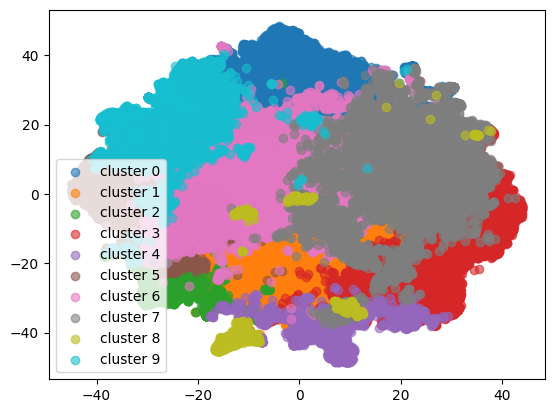

In [23]:
pdf = users_clustered.select([f'user_genre{i}' for i in range(19)] + ['cluster']).toPandas()
tsne = TSNE(n_components=2).fit_transform(pdf.drop(columns=['cluster'], axis=1).values)

for i in range(10):
    plt.scatter(tsne[pdf.cluster == i, 0], tsne[pdf.cluster == i, 1], label=f'cluster {i}', alpha=0.6)
plt.legend()

In [6]:
c3 = users_clustered.filter(sf.col('cluster') == 3).toPandas()[[f'user_genre{i}' for i in range(19)]].mean()
c5 = users_clustered.filter(sf.col('cluster') == 5).toPandas()[[f'user_genre{i}' for i in range(19)]].mean()

Распределение жанров "среднего" пользователя в кластере 3

<AxesSubplot: >

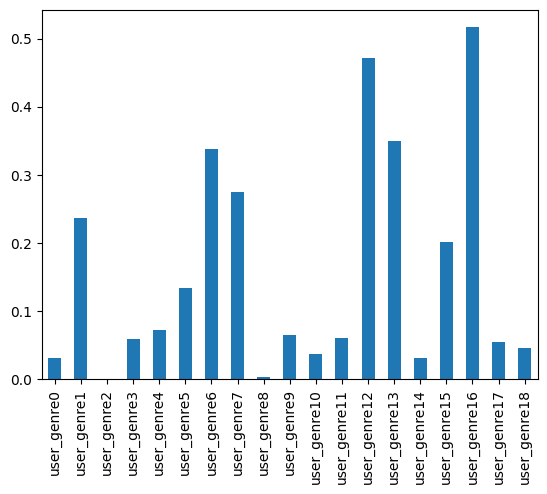

In [7]:
c3.plot(kind="bar", rot=90)

Распределение жанров "среднего" пользователя в кластере 5

<AxesSubplot: >

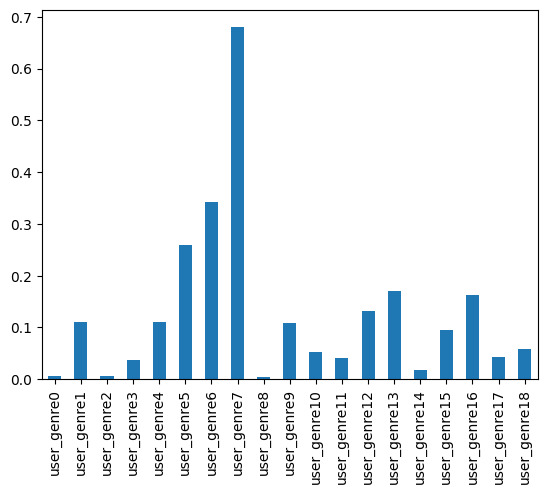

In [8]:
c5.plot(kind='bar', rot=90)

В ходе симуляции будут использованы генераторы только для 3 и 5 кластеров, чтобы можно было построить кривую значений метрики

In [7]:
# load generators for cluster 0 and cluster 3
user_generators = [
    SDVDataGenerator.load(f'{MODELS_DIR}/movielens_pca_users_c3_gaussiancopula.pkl'),
    SDVDataGenerator.load(f'{MODELS_DIR}/movielens_pca_users_c5_gaussiancopula.pkl')
]
for g in user_generators:
    g.setDevice('cpu')
    g.setParallelizationLevel(16)

user_gen = CompositeGenerator(user_generators, label='user_composite', weights=[0.5, 0.5])
_ = user_gen.generate(20000)

item_gen = RealDataGenerator(label='real_items', seed=1234)
item_gen.fit(items_df_train)
_ = item_gen.generate(items_df_train.count())

22/11/17 00:38:39 WARN CacheManager: Asked to cache already cached data.        


In [8]:
simulator = Simulator(
    user_gen=user_gen,
    item_gen=item_gen,
    data_dir=f'{CHECKPOINT_DIR}/movielens_scenario',
    user_key_col='user_id',
    item_key_col='item_id'
)

Строим пайплайн предсказания на основе LR. Полученную вероятность положительного отклика семплируем с помощью `BernoulliResponse`

In [9]:
va = VectorAssembler(
    inputCols=
        [f'user_features[{i}]' for i in range(9)] +\
        ['item_rating_avg'] +\
        [f'item_genre{i}' for i in range(19)] +\
        [f'item_w2v_{i}' for i in range(300)],
    outputCol='features'
)

lr = LogisticRegression(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='__lr_prob_vec'
)

vee = VectorElementExtractor(inputCol='__lr_prob_vec', outputCol='__lr_prob', index=1)
multiplier = ParametricResponseFunction(inputCols=['__lr_prob'], outputCol='__prob', weights=[0.5])
br = BernoulliResponse(inputCol='__prob', outputCol='response', seed=1234)

In [10]:
users_pca_df_train = pca.transform(users_df_train)\
    .withColumn('user_features', smf.vector_to_array('pca_features'))\
    .select(['user_id'] + [sf.col('user_features')[i] for i in range(9)])

response_train_df = log_df_val\
    .join(users_pca_df_train, 'user_id', 'left')\
    .join(items_df_train, 'item_id', 'left')\
    .drop('timestamp')\
    .na.drop()\
    .sample(0.1)

pipeline = Pipeline(stages=[va, lr, vee, multiplier, br]).fit(response_train_df)

Поверхность качества будем строить по метрике NDCG@10

In [11]:
evaluator = EvaluateMetrics(
    userKeyCol='user_id',
    itemKeyCol='item_id',
    predictionCol='relevance',
    labelCol='response',
    replay_label_filter=1.0,
    replay_metrics={NDCG() : 10}
)

In [12]:
indexer = Indexer(user_col='user_id', item_col='item_id')
indexer.fit(users=user_gen.sample(1.0), items=items_df_train)

Получаем массив "сценариев" (долей пользователей из каждой страты)

In [13]:
DISC = 10

fracs = []
for f1 in range(DISC + 1):
    f2 = DISC - f1
    fracs.append([f1 / DISC, f2 / DISC])

user_frac = 10000 / user_gen.getDataSize()
item_frac = 0.2

In [ ]:
dummy_log = pandas_to_spark(pd.DataFrame([{'user_idx' : 0, 'item_idx' : 0, 'relevance' : 0}])).cache()

surface_ndcg = []
for w in fracs:
    user_gen.setWeights(w)
    simulator.log_filename = f'log_{"_".join([str(w_i) for w_i in w])}.parquet'
    
    ucb = UCB(sample=True)
    ucb.fit(dummy_log)

    print(f'Current weights: {w}')

    for i in range(50):
        iter_start = time.time()

        users = simulator.sample_users(user_frac).cache()
        items = simulator.sample_items(item_frac).cache()
        log = simulator.get_log(users)
        if log is None:
            log = dummy_log
        log = log.cache()

        recs = ucb.predict(
            log=indexer.transform(log),
            k=10,
            users=indexer.transform(users),
            items=indexer.transform(items)
        )
        recs = indexer.inverse_transform(recs).cache()

        resp = simulator.sample_responses(
            recs_df=recs,
            user_features=users,
            item_features=items,
            action_models=pipeline
        ).select('user_id', 'item_id', 'relevance', 'response').cache()

        simulator.update_log(resp, iteration=i)
        ucb._clear_cache()
        train_log = simulator.log.cache()
        ucb.fit(
            log=indexer.transform(
                train_log.drop('relevance').withColumnRenamed('response', 'relevance')
            )
        )

        users.unpersist()
        items.unpersist()
        log.unpersist()
        recs.unpersist()
        resp.unpersist()
        train_log.unpersist()

        print(f'Iteration {i} ended in {time.time() - iter_start} sec.')

    users = simulator.sample_users(user_frac).cache()
    items = simulator.sample_items(item_frac).cache()
    log = simulator.get_log(users).cache()

    recs = ucb.predict(
        log=indexer.transform(log),
        k=10,
        users=indexer.transform(users),
        items=indexer.transform(items)
    )
    recs = indexer.inverse_transform(recs).cache()

    resp = simulator.sample_responses(
        recs_df=recs,
        user_features=users,
        item_features=items,
        action_models=pipeline
    ).select('user_id', 'item_id', 'relevance', 'response').cache()

    metrics = evaluator(resp)

    users.unpersist()
    items.unpersist()
    log.unpersist()
    recs.unpersist()
    resp.unpersist()

    surface_ndcg.append({'weight_c3' : w[0], 'weight_c5' : w[1], 'ndcg' : metrics['NDCG@10']})

dummy_log.unpersist()

Current weights: [0.0, 1.0]


22/11/17 00:39:49 WARN CacheManager: Asked to cache already cached data.
22/11/17 00:39:53 WARN DAGScheduler: Broadcasting large task binary with size 1106.7 KiB
22/11/17 00:39:55 WARN DAGScheduler: Broadcasting large task binary with size 1102.3 KiB
22/11/17 00:39:55 WARN DAGScheduler: Broadcasting large task binary with size 1136.7 KiB
22/11/17 00:39:56 WARN DAGScheduler: Broadcasting large task binary with size 1102.3 KiB
22/11/17 00:39:56 WARN DAGScheduler: Broadcasting large task binary with size 1135.3 KiB
22/11/17 00:40:12 WARN DAGScheduler: Broadcasting large task binary with size 1382.8 KiB
22/11/17 00:40:12 WARN DAGScheduler: Broadcasting large task binary with size 1398.4 KiB
22/11/17 00:40:13 WARN DAGScheduler: Broadcasting large task binary with size 1817.9 KiB


Iteration 0 ended in 35.23294448852539 sec.


22/11/17 00:40:30 WARN DAGScheduler: Broadcasting large task binary with size 1106.7 KiB
22/11/17 00:40:31 WARN DAGScheduler: Broadcasting large task binary with size 1102.2 KiB
22/11/17 00:40:32 WARN DAGScheduler: Broadcasting large task binary with size 1140.1 KiB
22/11/17 00:40:33 WARN DAGScheduler: Broadcasting large task binary with size 1102.2 KiB
22/11/17 00:40:33 WARN DAGScheduler: Broadcasting large task binary with size 1138.7 KiB
22/11/17 00:40:34 WARN DAGScheduler: Broadcasting large task binary with size 1644.9 KiB
22/11/17 00:40:34 WARN DAGScheduler: Broadcasting large task binary with size 1693.3 KiB
22/11/17 00:40:35 WARN DAGScheduler: Broadcasting large task binary with size 1694.5 KiB
22/11/17 00:40:43 WARN DAGScheduler: Broadcasting large task binary with size 1643.9 KiB
22/11/17 00:40:43 WARN DAGScheduler: Broadcasting large task binary with size 1644.1 KiB
22/11/17 00:40:43 WARN DAGScheduler: Broadcasting large task binary with size 1664.0 KiB
22/11/17 00:40:44 WAR

Iteration 1 ended in 34.89193344116211 sec.


22/11/17 00:41:07 WARN DAGScheduler: Broadcasting large task binary with size 1106.7 KiB
22/11/17 00:41:08 WARN DAGScheduler: Broadcasting large task binary with size 1102.2 KiB
22/11/17 00:41:09 WARN DAGScheduler: Broadcasting large task binary with size 1140.1 KiB
22/11/17 00:41:10 WARN DAGScheduler: Broadcasting large task binary with size 1102.2 KiB
22/11/17 00:41:10 WARN DAGScheduler: Broadcasting large task binary with size 1138.7 KiB
22/11/17 00:41:11 WARN DAGScheduler: Broadcasting large task binary with size 1644.9 KiB
22/11/17 00:41:12 WARN DAGScheduler: Broadcasting large task binary with size 1693.3 KiB
22/11/17 00:41:12 WARN DAGScheduler: Broadcasting large task binary with size 1694.5 KiB
22/11/17 00:41:21 WARN DAGScheduler: Broadcasting large task binary with size 1643.9 KiB
22/11/17 00:41:21 WARN DAGScheduler: Broadcasting large task binary with size 1644.1 KiB
22/11/17 00:41:21 WARN DAGScheduler: Broadcasting large task binary with size 1664.0 KiB
22/11/17 00:41:22 WAR

Iteration 2 ended in 38.12671089172363 sec.


22/11/17 00:41:44 WARN DAGScheduler: Broadcasting large task binary with size 1106.7 KiB
22/11/17 00:41:45 WARN DAGScheduler: Broadcasting large task binary with size 1102.2 KiB
22/11/17 00:41:45 WARN DAGScheduler: Broadcasting large task binary with size 1140.1 KiB
22/11/17 00:41:47 WARN DAGScheduler: Broadcasting large task binary with size 1102.2 KiB
22/11/17 00:41:47 WARN DAGScheduler: Broadcasting large task binary with size 1138.7 KiB
22/11/17 00:41:48 WARN DAGScheduler: Broadcasting large task binary with size 1644.9 KiB
22/11/17 00:41:49 WARN DAGScheduler: Broadcasting large task binary with size 1693.3 KiB
22/11/17 00:41:49 WARN DAGScheduler: Broadcasting large task binary with size 1694.5 KiB
22/11/17 00:41:57 WARN DAGScheduler: Broadcasting large task binary with size 1644.1 KiB
22/11/17 00:41:57 WARN DAGScheduler: Broadcasting large task binary with size 1643.9 KiB
22/11/17 00:41:58 WARN DAGScheduler: Broadcasting large task binary with size 1798.5 KiB
22/11/17 00:41:58 WAR

Iteration 3 ended in 34.501567125320435 sec.


22/11/17 00:42:18 WARN DAGScheduler: Broadcasting large task binary with size 1106.7 KiB
22/11/17 00:42:19 WARN DAGScheduler: Broadcasting large task binary with size 1102.2 KiB
22/11/17 00:42:20 WARN DAGScheduler: Broadcasting large task binary with size 1140.1 KiB
22/11/17 00:42:20 WARN DAGScheduler: Broadcasting large task binary with size 1102.2 KiB
22/11/17 00:42:21 WARN DAGScheduler: Broadcasting large task binary with size 1138.7 KiB
22/11/17 00:42:21 WARN DAGScheduler: Broadcasting large task binary with size 1644.9 KiB
22/11/17 00:42:22 WARN DAGScheduler: Broadcasting large task binary with size 1693.3 KiB
22/11/17 00:42:23 WARN DAGScheduler: Broadcasting large task binary with size 1694.5 KiB
22/11/17 00:42:31 WARN DAGScheduler: Broadcasting large task binary with size 1644.1 KiB
22/11/17 00:42:31 WARN DAGScheduler: Broadcasting large task binary with size 1643.9 KiB
22/11/17 00:42:32 WARN DAGScheduler: Broadcasting large task binary with size 1798.8 KiB
22/11/17 00:42:32 WAR

Iteration 4 ended in 34.83822154998779 sec.


22/11/17 00:42:53 WARN DAGScheduler: Broadcasting large task binary with size 1106.7 KiB
22/11/17 00:42:54 WARN DAGScheduler: Broadcasting large task binary with size 1102.2 KiB
22/11/17 00:42:55 WARN DAGScheduler: Broadcasting large task binary with size 1140.1 KiB
22/11/17 00:42:56 WARN DAGScheduler: Broadcasting large task binary with size 1102.2 KiB
22/11/17 00:42:56 WARN DAGScheduler: Broadcasting large task binary with size 1138.7 KiB
22/11/17 00:42:57 WARN DAGScheduler: Broadcasting large task binary with size 1644.9 KiB
22/11/17 00:42:57 WARN DAGScheduler: Broadcasting large task binary with size 1693.3 KiB
22/11/17 00:42:58 WARN DAGScheduler: Broadcasting large task binary with size 1694.5 KiB
22/11/17 00:43:05 WARN DAGScheduler: Broadcasting large task binary with size 1643.9 KiB
22/11/17 00:43:05 WARN DAGScheduler: Broadcasting large task binary with size 1644.1 KiB
22/11/17 00:43:06 WARN DAGScheduler: Broadcasting large task binary with size 1664.0 KiB
22/11/17 00:43:06 WAR

Iteration 5 ended in 34.394606590270996 sec.


22/11/17 00:43:28 WARN DAGScheduler: Broadcasting large task binary with size 1106.7 KiB
22/11/17 00:43:29 WARN DAGScheduler: Broadcasting large task binary with size 1102.2 KiB
22/11/17 00:43:30 WARN DAGScheduler: Broadcasting large task binary with size 1140.1 KiB
22/11/17 00:43:30 WARN DAGScheduler: Broadcasting large task binary with size 1102.2 KiB
22/11/17 00:43:31 WARN DAGScheduler: Broadcasting large task binary with size 1138.7 KiB
22/11/17 00:43:31 WARN DAGScheduler: Broadcasting large task binary with size 1644.9 KiB
22/11/17 00:43:32 WARN DAGScheduler: Broadcasting large task binary with size 1693.3 KiB
22/11/17 00:43:33 WARN DAGScheduler: Broadcasting large task binary with size 1694.5 KiB
22/11/17 00:43:40 WARN DAGScheduler: Broadcasting large task binary with size 1643.9 KiB
22/11/17 00:43:40 WARN DAGScheduler: Broadcasting large task binary with size 1644.1 KiB
22/11/17 00:43:41 WARN DAGScheduler: Broadcasting large task binary with size 1664.0 KiB
22/11/17 00:43:41 WAR

Iteration 6 ended in 35.759753942489624 sec.


22/11/17 00:44:04 WARN DAGScheduler: Broadcasting large task binary with size 1106.7 KiB
22/11/17 00:44:05 WARN DAGScheduler: Broadcasting large task binary with size 1102.2 KiB
22/11/17 00:44:06 WARN DAGScheduler: Broadcasting large task binary with size 1140.1 KiB
22/11/17 00:44:06 WARN DAGScheduler: Broadcasting large task binary with size 1102.2 KiB
22/11/17 00:44:07 WARN DAGScheduler: Broadcasting large task binary with size 1138.7 KiB
22/11/17 00:44:07 WARN DAGScheduler: Broadcasting large task binary with size 1644.9 KiB
22/11/17 00:44:08 WARN DAGScheduler: Broadcasting large task binary with size 1693.3 KiB
22/11/17 00:44:09 WARN DAGScheduler: Broadcasting large task binary with size 1694.5 KiB
22/11/17 00:44:16 WARN DAGScheduler: Broadcasting large task binary with size 1644.1 KiB
22/11/17 00:44:16 WARN DAGScheduler: Broadcasting large task binary with size 1643.9 KiB
22/11/17 00:44:17 WARN DAGScheduler: Broadcasting large task binary with size 1800.1 KiB
22/11/17 00:44:17 WAR

Iteration 7 ended in 36.869606733322144 sec.


22/11/17 00:44:41 WARN DAGScheduler: Broadcasting large task binary with size 1106.7 KiB
22/11/17 00:44:43 WARN DAGScheduler: Broadcasting large task binary with size 1102.2 KiB
22/11/17 00:44:43 WARN DAGScheduler: Broadcasting large task binary with size 1140.1 KiB
22/11/17 00:44:44 WARN DAGScheduler: Broadcasting large task binary with size 1102.2 KiB
22/11/17 00:44:44 WARN DAGScheduler: Broadcasting large task binary with size 1138.7 KiB
22/11/17 00:44:45 WARN DAGScheduler: Broadcasting large task binary with size 1644.9 KiB
22/11/17 00:44:46 WARN DAGScheduler: Broadcasting large task binary with size 1693.3 KiB
22/11/17 00:44:46 WARN DAGScheduler: Broadcasting large task binary with size 1694.5 KiB
22/11/17 00:44:53 WARN DAGScheduler: Broadcasting large task binary with size 1644.1 KiB
22/11/17 00:44:53 WARN DAGScheduler: Broadcasting large task binary with size 1643.9 KiB
22/11/17 00:44:54 WARN DAGScheduler: Broadcasting large task binary with size 1798.8 KiB
22/11/17 00:44:57 WAR

Iteration 8 ended in 37.79725909233093 sec.


22/11/17 00:45:20 WARN DAGScheduler: Broadcasting large task binary with size 1106.7 KiB
22/11/17 00:45:21 WARN DAGScheduler: Broadcasting large task binary with size 1102.2 KiB
22/11/17 00:45:21 WARN DAGScheduler: Broadcasting large task binary with size 1140.1 KiB
22/11/17 00:45:22 WARN DAGScheduler: Broadcasting large task binary with size 1102.2 KiB
22/11/17 00:45:22 WARN DAGScheduler: Broadcasting large task binary with size 1138.7 KiB
22/11/17 00:45:23 WARN DAGScheduler: Broadcasting large task binary with size 1644.9 KiB
22/11/17 00:45:23 WARN DAGScheduler: Broadcasting large task binary with size 1693.3 KiB
22/11/17 00:45:24 WARN DAGScheduler: Broadcasting large task binary with size 1694.5 KiB
22/11/17 00:45:32 WARN DAGScheduler: Broadcasting large task binary with size 1644.1 KiB
22/11/17 00:45:32 WARN DAGScheduler: Broadcasting large task binary with size 1643.9 KiB
22/11/17 00:45:32 WARN DAGScheduler: Broadcasting large task binary with size 1795.8 KiB
22/11/17 00:45:33 WAR

Iteration 9 ended in 38.37948942184448 sec.


22/11/17 00:45:58 WARN DAGScheduler: Broadcasting large task binary with size 1106.7 KiB
22/11/17 00:46:00 WARN DAGScheduler: Broadcasting large task binary with size 1102.2 KiB
22/11/17 00:46:00 WARN DAGScheduler: Broadcasting large task binary with size 1140.1 KiB
22/11/17 00:46:01 WARN DAGScheduler: Broadcasting large task binary with size 1102.2 KiB
22/11/17 00:46:01 WARN DAGScheduler: Broadcasting large task binary with size 1138.7 KiB
22/11/17 00:46:02 WARN DAGScheduler: Broadcasting large task binary with size 1644.9 KiB
22/11/17 00:46:03 WARN DAGScheduler: Broadcasting large task binary with size 1693.3 KiB
22/11/17 00:46:04 WARN DAGScheduler: Broadcasting large task binary with size 1694.5 KiB
22/11/17 00:46:11 WARN DAGScheduler: Broadcasting large task binary with size 1644.1 KiB
22/11/17 00:46:11 WARN DAGScheduler: Broadcasting large task binary with size 1643.9 KiB
22/11/17 00:46:12 WARN DAGScheduler: Broadcasting large task binary with size 1799.1 KiB
22/11/17 00:46:12 WAR

Iteration 10 ended in 39.74881553649902 sec.


22/11/17 00:46:38 WARN DAGScheduler: Broadcasting large task binary with size 1106.7 KiB
22/11/17 00:46:40 WARN DAGScheduler: Broadcasting large task binary with size 1102.2 KiB
22/11/17 00:46:40 WARN DAGScheduler: Broadcasting large task binary with size 1140.1 KiB
22/11/17 00:46:41 WARN DAGScheduler: Broadcasting large task binary with size 1102.2 KiB
22/11/17 00:46:41 WARN DAGScheduler: Broadcasting large task binary with size 1138.7 KiB
22/11/17 00:46:42 WARN DAGScheduler: Broadcasting large task binary with size 1644.9 KiB
22/11/17 00:46:43 WARN DAGScheduler: Broadcasting large task binary with size 1693.3 KiB
22/11/17 00:46:44 WARN DAGScheduler: Broadcasting large task binary with size 1694.5 KiB
22/11/17 00:46:51 WARN DAGScheduler: Broadcasting large task binary with size 1643.9 KiB
22/11/17 00:46:51 WARN DAGScheduler: Broadcasting large task binary with size 1644.1 KiB
22/11/17 00:46:51 WARN DAGScheduler: Broadcasting large task binary with size 1664.0 KiB
22/11/17 00:46:52 WAR

Iteration 11 ended in 41.16243624687195 sec.


22/11/17 00:47:21 WARN DAGScheduler: Broadcasting large task binary with size 1106.7 KiB
22/11/17 00:47:22 WARN DAGScheduler: Broadcasting large task binary with size 1102.2 KiB
22/11/17 00:47:22 WARN DAGScheduler: Broadcasting large task binary with size 1140.1 KiB
22/11/17 00:47:23 WARN DAGScheduler: Broadcasting large task binary with size 1102.2 KiB
22/11/17 00:47:23 WARN DAGScheduler: Broadcasting large task binary with size 1138.7 KiB
22/11/17 00:47:24 WARN DAGScheduler: Broadcasting large task binary with size 1644.9 KiB
22/11/17 00:47:25 WARN DAGScheduler: Broadcasting large task binary with size 1693.3 KiB
22/11/17 00:47:26 WARN DAGScheduler: Broadcasting large task binary with size 1694.5 KiB
22/11/17 00:47:33 WARN DAGScheduler: Broadcasting large task binary with size 1643.9 KiB
22/11/17 00:47:33 WARN DAGScheduler: Broadcasting large task binary with size 1644.1 KiB
22/11/17 00:47:34 WARN DAGScheduler: Broadcasting large task binary with size 1664.0 KiB
22/11/17 00:47:35 WAR

Iteration 12 ended in 42.7676203250885 sec.


22/11/17 00:48:03 WARN DAGScheduler: Broadcasting large task binary with size 1106.7 KiB
22/11/17 00:48:04 WARN DAGScheduler: Broadcasting large task binary with size 1102.2 KiB
22/11/17 00:48:05 WARN DAGScheduler: Broadcasting large task binary with size 1140.1 KiB
22/11/17 00:48:05 WARN DAGScheduler: Broadcasting large task binary with size 1102.2 KiB
22/11/17 00:48:06 WARN DAGScheduler: Broadcasting large task binary with size 1138.7 KiB
22/11/17 00:48:06 WARN DAGScheduler: Broadcasting large task binary with size 1644.9 KiB
22/11/17 00:48:07 WARN DAGScheduler: Broadcasting large task binary with size 1693.3 KiB
22/11/17 00:48:09 WARN DAGScheduler: Broadcasting large task binary with size 1694.5 KiB
22/11/17 00:48:15 WARN DAGScheduler: Broadcasting large task binary with size 1644.1 KiB
22/11/17 00:48:15 WARN DAGScheduler: Broadcasting large task binary with size 1643.9 KiB
22/11/17 00:48:17 WARN DAGScheduler: Broadcasting large task binary with size 1798.1 KiB
22/11/17 00:48:17 WAR

Iteration 13 ended in 42.602540016174316 sec.


22/11/17 00:48:46 WARN DAGScheduler: Broadcasting large task binary with size 1106.7 KiB
22/11/17 00:48:47 WARN DAGScheduler: Broadcasting large task binary with size 1102.2 KiB
22/11/17 00:48:47 WARN DAGScheduler: Broadcasting large task binary with size 1140.1 KiB
22/11/17 00:48:48 WARN DAGScheduler: Broadcasting large task binary with size 1102.2 KiB
22/11/17 00:48:49 WARN DAGScheduler: Broadcasting large task binary with size 1138.7 KiB
22/11/17 00:48:49 WARN DAGScheduler: Broadcasting large task binary with size 1644.9 KiB
22/11/17 00:48:50 WARN DAGScheduler: Broadcasting large task binary with size 1693.3 KiB
22/11/17 00:48:51 WARN DAGScheduler: Broadcasting large task binary with size 1694.5 KiB
22/11/17 00:48:59 WARN DAGScheduler: Broadcasting large task binary with size 1644.1 KiB
22/11/17 00:48:59 WARN DAGScheduler: Broadcasting large task binary with size 1643.9 KiB
22/11/17 00:49:00 WARN DAGScheduler: Broadcasting large task binary with size 1797.8 KiB
22/11/17 00:49:00 WAR

Iteration 14 ended in 43.847657203674316 sec.


22/11/17 00:49:30 WARN DAGScheduler: Broadcasting large task binary with size 1106.7 KiB


In [17]:
surface_pdf = pd.DataFrame(surface_ndcg)
surface_pdf.to_csv('../bin/ml_scenario_ndcg.csv', index=False)

(0.65, 0.75)

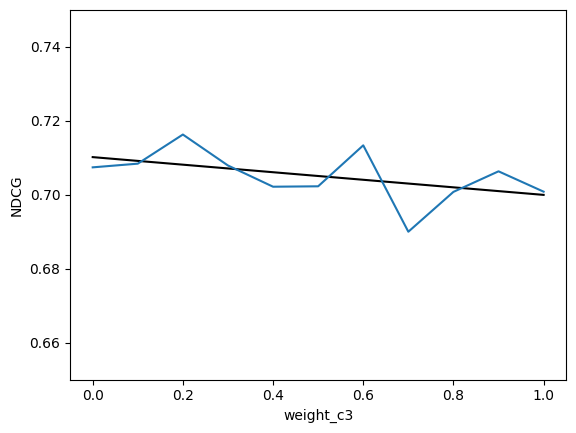

In [13]:
surface_pdf = pd.read_csv('../bin/ml_scenario_ndcg.csv')

def draw_trend(x, y):
    trend = np.polyfit(x, y, 1)
    result = trend[0]*x + trend[1]
    return result

plt.plot(surface_pdf['weight_c3'], draw_trend(surface_pdf['weight_c3'], surface_pdf['ndcg']), color='k')
plt.plot(surface_pdf['weight_c3'], surface_pdf['ndcg'])

plt.xlabel("weight_c3")
plt.ylabel("NDCG")
plt.ylim(0.65, 0.75)

Из распределении жанров видно, что в кластере 3 жанры более разнообразны, чем в кластере 5, тем самым при увеличении количества пользователей из 3-его кластера метрика падает, так как появляется больше релевантных итемов